## Курсовая работа 

#### Студента группы J4112 Данилова Сергея

In [1029]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.layers import LSTM, Input, Dense, Conv1D, Flatten, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
import time
from pytrends.request import TrendReq
import seaborn as sns
from sklearn.metrics import classification_report, RocCurveDisplay, roc_auc_score, mean_absolute_percentage_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


Загрузим данные о цене акции МосБиржи с 2013 по 2022 год

In [848]:
df = pd.read_csv("MOEX_070105_221221.csv")
df = df.drop(["<TIME>", "<TICKER>", "<PER>", "<OPEN>", "<HIGH>", "<LOW>", "<VOL>"], axis=1)
df["<DATE>"] = pd.to_datetime(df["<DATE>"], format="%Y%m%d")
df

,<DATE>,<CLOSE>
0,2013-02-11,55.00
1,2013-02-18,54.50
2,2013-02-25,52.50
3,2013-03-04,53.99
4,2013-03-11,55.00
...,...,...
507,2022-11-21,87.60
508,2022-11-28,87.02
509,2022-12-05,88.17
510,2022-12-12,84.95


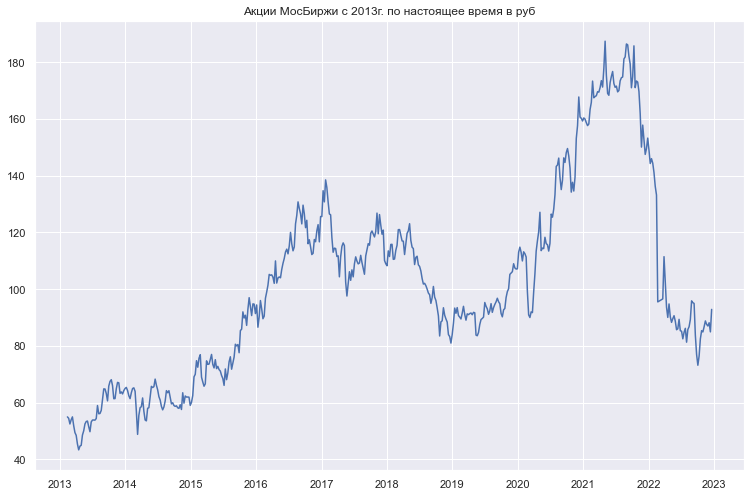

In [921]:
plt.plot(df["<DATE>"], df["<CLOSE>"])
plt.title("Акции МосБиржи с 2013г. по настоящее время в руб")
plt.show()

Загрузим данные о трендах слов, связанных с экономикой и политикой РФ с сервиса Google trends

In [911]:
%%script false

pytrend = TrendReq()

def make_gtrend_table(word, year = 2013):
    ress = pd.DataFrame()
    for y in range(year, 2023):
        str_yr = str(y)
        pytrend.build_payload([word], timeframe=f"{y}-01-01 {y+1}-01-01")
        result = pytrend.interest_over_time()
        ress = pd.concat([ress, result])
    return ress

lst_of_words = ["мосбиржа", "долг", "инвестор", "экономика", "акции", "инвестиции", "портфель", "инфляция", \
    "кризис", "кредит", "доход", "капитал", "вложить", "война", "заболеваемость", "правительство", \
    "закон", "парламент", "сбербанк", "газпром", "роснефть", "нефть", "короновирус", "covid",  \
    "санкции", "США", "газ", "вклад", "депозит", "облигация", "оружие", "спрос", "новости", "украина",\
    "германия", "тинькофф", "центробанк", "какие акции купить в 2022",  "акции сбербанка курс", \
    "индекс мосбиржи", "vk акции", "акции входящие в состав мосбиржи", "газета ру", "риа новости", \
    "рбк инвестиции", "нефть брент", "курс доллара", "курс евро", "яндекс"]

def get_pytrend_data(lst_of_words, cols):
    count = 0
    for term in lst_of_words:
        print(f"{term} get")
        c = 0
        while (c < 5):
            try:
                res = make_gtrend_table(term)
                cols[term] = res
                break
            except:
                time.sleep(5)
                c+=1


cols = {}
get_pytrend_data(lst_of_words, cols)
total_trend_data = pd.concat(cols.values(), axis=1)
total_trend_data = total_trend_data.drop(["isPartial"], axis=1)
total_trend_data["date"] = total_trend_data.index
total_trend_data["date"] = total_trend_data.apply(lambda x: x["date"] + pd.DateOffset(days=1), axis=1)
total_trend_data = total_trend_data.set_index("date")
total_trend_data.to_csv("total_trend_data.csv")
display(total_trend_data)

Couldn't find program: 'false'


Соединим две таблицы

In [916]:
total_trend_data = pd.read_csv("total_trend_data.csv")
total_trend_data["date"] = pd.to_datetime(total_trend_data["date"], format="%Y-%m-%d")
total_trend_data["date"] = total_trend_data.apply(lambda x: x["date"] + pd.DateOffset(days=1), axis=1)
total_trend_data = total_trend_data.set_index("date")
display(total_trend_data)

,мосбиржа,долг,инвестор,экономика,акции,инвестиции,портфель,инфляция,кризис,кредит,...,какие акции купить в 2022,акции сбербанка курс,индекс мосбиржи,vk акции,газета ру,риа новости,рбк инвестиции,нефть брент,курс доллара,курс евро
date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,0,61,61,56,37,63,41,68,60,77,...,0,0,0,0,85,24,69,0,56,55
2013-01-14,0,72,62,74,38,76,65,73,71,81,...,0,41,0,0,74,33,43,0,59,52
2013-01-21,100,67,86,73,40,81,62,78,65,83,...,0,0,0,0,74,35,0,0,59,49
2013-01-28,0,74,59,62,41,77,64,67,60,85,...,34,0,32,0,68,34,0,0,60,52
2013-02-04,0,71,56,65,40,79,57,67,57,90,...,0,0,0,0,71,36,100,89,59,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21,7,56,45,48,30,39,68,29,40,71,...,0,1,11,0,30,28,22,25,9,16
2022-11-28,6,55,49,48,30,39,75,29,40,74,...,0,0,9,6,28,24,23,30,10,17
2022-12-05,8,57,56,52,32,40,72,29,41,75,...,0,1,9,0,31,27,20,41,11,20


Соединим две таблицы

In [923]:
res = []
for i in df.index:
    try:
        int(total_trend_data.iloc[i, 2])
        res.append([df.loc[i, "<DATE>"], df.loc[i, "<CLOSE>"], *total_trend_data.iloc[i,:]])
    except Exception as e:
        print(f"{e}")
        continue
res = pd.DataFrame(res, columns = ["date", "price", *total_trend_data.columns])
res = res.set_index("date")
res

,price,мосбиржа,долг,инвестор,экономика,акции,инвестиции,портфель,инфляция,кризис,...,какие акции купить в 2022,акции сбербанка курс,индекс мосбиржи,vk акции,газета ру,риа новости,рбк инвестиции,нефть брент,курс доллара,курс евро
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,55.00,0,61,61,56,37,63,41,68,60,...,0,0,0,0,85,24,69,0,56,55
2013-02-18,54.50,0,72,62,74,38,76,65,73,71,...,0,41,0,0,74,33,43,0,59,52
2013-02-25,52.50,100,67,86,73,40,81,62,78,65,...,0,0,0,0,74,35,0,0,59,49
2013-03-04,53.99,0,74,59,62,41,77,64,67,60,...,34,0,32,0,68,34,0,0,60,52
2013-03-11,55.00,0,71,56,65,40,79,57,67,57,...,0,0,0,0,71,36,100,89,59,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21,87.60,23,56,55,58,36,50,73,26,41,...,9,2,48,29,42,44,13,25,17,24
2022-11-28,87.02,25,53,44,58,33,47,75,27,56,...,0,3,39,16,43,48,38,38,18,30
2022-12-05,88.17,11,57,42,54,37,40,74,25,54,...,0,0,11,18,38,40,25,24,15,25


Построим корреляционную матрицу. Корреляция здесь считается по методу Пирсона

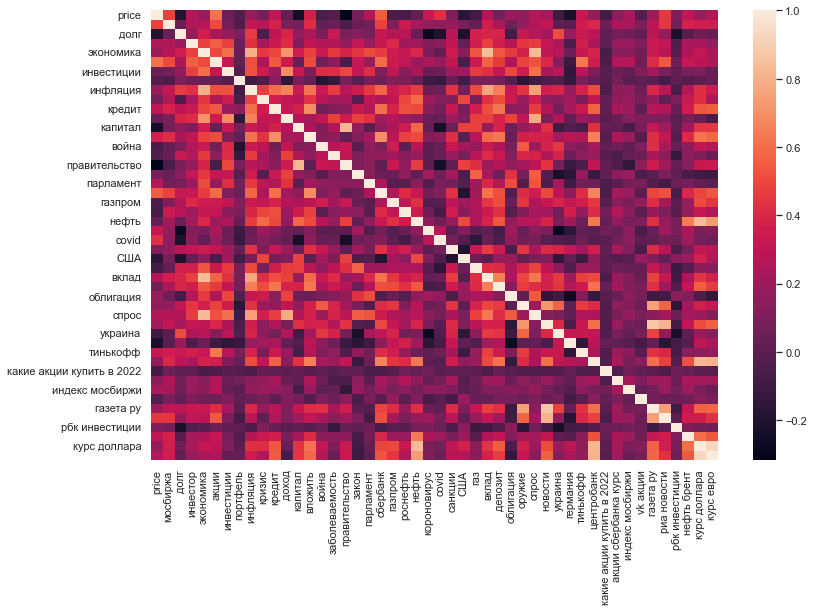

BEST SEARCHES (r>0.3)


In [924]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
sns.heatmap(res.corr())
plt.show()
print("BEST SEARCHES (r>0.3)")
corrl = []
kws = res.corr()["price"].keys()
corrdf = res.corr()["price"]
for i in range(len(kws)):
    if (corrdf[kws[i]] > 0.3 or corrdf[kws[i]] < -0.3):
        corrl.append((i, kws[i], round(corrdf[kws[i]], 3) ))
best_corr = pd.DataFrame(corrl, columns = ["idx","parameter", "correlation"])

Выведем слова, которые имеют корреляцию с ценой акции больше 0.3 по модулю. Для оценки правдоподобия вычислим p-value 

In [926]:
from scipy.stats import pearsonr
best_corr["p-value"] = 0
for cidx in range(1, 11):
    c = best_corr.loc[cidx, "parameter"]
    column_corr = pearsonr(res[c], res["price"])
    best_corr.loc[cidx, "p-value"] = round(column_corr.pvalue, 2)
best_corr

,idx,parameter,correlation,p-value
0,0,price,1.000,0
1,1,мосбиржа,0.471,0
2,5,акции,0.605,0
3,10,кредит,0.302,0
4,13,вложить,0.366,0
5,16,правительство,-0.316,0
6,19,сбербанк,0.551,0
7,23,короновирус,0.329,0
8,24,covid,0.428,0
9,36,тинькофф,0.329,0


Повторим такие же действия для других позиций

Получили поисковые запросы, коррелирующие с ценой для всех компаний и по отдельности:

Из этого можно сделать вывод, что популярность некотороых поисковых запросов имеет связь с ценами акций российских компаний. Далее попытаемся использовать найденные слова для построения модели Машинного Обучения для предсказания следующих цен акций по поисковым трендам в прошлом и настоящем.

## Построение моделей Машинного обучения


### Модели классификации движения акций

Выделим признак с повышением цены. Если текущая цена увеличилась по сравнению с прошлой неделей, ставим 1, иначе 0. Все значения нормируем с помощью Standard Scaler метода для совпадения масштабов

In [1013]:
table_lag = res.copy()
table_lag["up"] = 0
for i in range(1, len(table_lag)):
    if (table_lag.iloc[i, 0] >= table_lag.iloc[i-1, 0] ):
        table_lag.iloc[i, -1] = 1
scaler = StandardScaler()
scaler = scaler.fit(table_lag.iloc[:, :-1])
pricedata_scaled = scaler.transform(table_lag.iloc[:, :-1])
pricedata_scaled = np.hstack([pricedata_scaled, table_lag.iloc[:, -1:]])

Разделим данные на окна фиксированной длины. В зависимости от задачи будем в X хранить цену и тренды недели, или только цену или только тренды

In [1033]:
def prepare_data(winsize = 2, params_set="all", flatten=True):
    X = []
    y = []
    for i in range(pricedata_scaled.shape[0]-winsize):
        X_tmp = None
        if (params_set == "all"):
            X_tmp = pricedata_scaled[i:i+winsize, best_corr["idx"]]
        elif (params_set == "keywords"):
            X_tmp = pricedata_scaled[i:i+winsize, best_corr["idx"][1:]]
        else:
            X_tmp = pricedata_scaled[i:i+winsize, 0:1]
        if (flatten):
            X_tmp = X_tmp.ravel()
        X.append(X_tmp)
        y.append(pricedata_scaled[i+winsize, -1])
    X = np.array(X)
    y = np.array(y)
    tsplit_idx = int(len(X)*0.8)
    X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

    return X_train, X_test, y_train, y_test

#prepare_data(2, "price", False)


Введем функции для построения моделей. Для настройки Random Forest Classifier будем исопльзовать GridSearch.

In [1024]:
def train_rfr(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier()
    prms = {
        "n_estimators": [10, 50, 100,],
        # "max_depth": [1, 2],
        # "min_samples_split" :[2, 3, 5],
        # "min_samples_leaf" : [1, 2, 5, 7]
    }
    gscv = GridSearchCV(model, param_grid=prms)
    gscv.fit(X_train, y_train)
    model = gscv.best_estimator_
    y_pred = model.predict(X_test, verbose=0)
    auc = roc_auc_score(y_test, y_pred)
    acc = classification_report(y_test, y_pred, output_dict=True)["accuracy"]
    return [auc, acc]

train_rfr(*prepare_data())


X shape (408, 24) test shape (102, 24) y shape (408,)


[0.5619230769230769, 0.5686274509803921]

В качестве MLP будем использовать 2 слоя с регуляризацией L2. Она понадобится чтобы отсечи ненужные признаки - некоррелирующие ключевые слова

In [1025]:
def train_mlp(X_train, X_test, y_train, y_test):
    model = Sequential()
    param_num=X_train.shape[1]
    model.add(Input((param_num)))
    model.add(Dense(64, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(32, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(metrics="accuracy", loss="binary_crossentropy")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    y_pred_bin = [0 if i < 0.5 else 1 for i in y_pred]
    auc = roc_auc_score(y_test, y_pred_bin)
    acc = classification_report(y_test, y_pred_bin, output_dict=True)["accuracy"]
    return [auc, acc]

И посторим LSTM с 64 параметрами в качестве вектора состояний и регуляризацией весов

In [ ]:
def train_lstm(X_train, X_test, y_train, y_test):
    model = Sequential()
    param_num=X_train.shape[2]
    winsize=X_train.shape[1]
    model.add(Input((winsize, param_num)))
    model.add(LSTM(64, return_sequences=False, kernel_regularizer="l2"))
    model.add(Dense(16, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(metrics="accuracy", loss="binary_crossentropy")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    y_pred_bin = [0 if i < 0.5 else 1 for i in y_pred]
    auc = roc_auc_score(y_test, y_pred_bin)
    acc = classification_report(y_test, y_pred_bin, output_dict=True)["accuracy"]
    return [auc, acc]

train_lstm(*prepare_data(winsize=3, params_set="price", flatten=False))

Подберем наилучшие параметры и оценим результат по метрике accuracy, precision, recall, F1 и AUC

In [1034]:
results = []
for i in range(1, 6):
    for j in ["all", "keywords", "price"]:
        ress = train_rfr(*prepare_data(winsize=i, params_set=j, flatten=True))
        results.append(["RFR", i, j, *ress])
for i in range(1, 6):
    for j in ["all", "keywords", "price"]:
        ress = train_mlp(*prepare_data(winsize=i, params_set=j, flatten=True))
        results.append(["MLP", i, j, *ress])
for i in range(1, 6):
    for j in ["all", "keywords", "price"]:
        ress = train_lstm(*prepare_data(winsize=i, params_set=j, flatten=False))
        results.append(["LSTM", i, j, *ress])

4/4 [==============================] - 0s 4ms/step


Соберем наши измерения в сводную таблицу и сравним по метрикам Accuracy и AUC

In [1030]:
pd.DataFrame(results, columns = ["Model", "Window", "Data", "Accuracy", "AUC"])

,Model,Window,Data,Accuracy,AUC
0,RFR,1,all,0.470189,0.475728
1,RFR,1,keywords,0.490189,0.495146
2,RFR,1,price,0.513208,0.504854
3,RFR,2,all,0.473846,0.480392
4,RFR,2,keywords,0.548462,0.549020
5,RFR,2,price,0.488077,0.490196
6,RFR,3,all,0.492308,0.500000
7,RFR,3,keywords,0.453846,0.460784
8,RFR,3,price,0.506154,0.509804
9,RFR,4,all,0.512308,0.519608


### Вывод

получили R2 0.999

### Построение моделей регрессии цены акций

Подготовим данные, используя Standard Scaler

In [1005]:
scaler = MinMaxScaler()
scaler = scaler.fit(res)
pricedata_scaled = scaler.transform(res)
pricedata_scaled[:, 1:] = np.log(pricedata_scaled[:, 1:]+0.001)

Аналогичная функция разбиения на окна и тренировочную и тестирующую часть

In [981]:
def prepare_data(winsize = 2, params_set="all", flatten=True):
    X = []
    y = []
    for i in range(pricedata_scaled.shape[0]-winsize):
        X_tmp = None
        if (params_set == "all"):
            X_tmp = pricedata_scaled[i:i+winsize, best_corr["idx"]]
        elif (params_set == "keywords"):
            X_tmp = pricedata_scaled[i:i+winsize, best_corr["idx"][1:]]
        else:
            X_tmp = pricedata_scaled[i:i+winsize, 0:1]
        if (flatten):
            X_tmp = X_tmp.ravel()
        X.append(X_tmp)
        y.append(pricedata_scaled[i+winsize, 0])
    X = np.array(X)
    y = np.array(y)
    tsplit_idx = int(len(X)*0.8)
    X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

    return X_train, X_test, y_train, y_test

#prepare_data(2, "price", False)

Используем Random Forest Regressor, параметры которого подберем с GridSearch. Метрикой всех методов будет mean Abolute percentage error (mAPE), а функцией ошибки MSE.

In [1010]:
def train_rfr(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test, verbose=0)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    return [mape, mse, r2]

В качестве MLP используем двухслойную нейросеть с регуляризацией

In [960]:
def train_mlp(X_train, X_test, y_train, y_test):
    model = Sequential()
    param_num=X_train.shape[1]
    model.add(Input((param_num)))
    model.add(Dense(64, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(32, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(metrics="mape", loss="mse", optimizer=Adam(0.001))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    return [mape, mse, r2]

Также используем LSTM сеть с линейным выходом.

In [985]:
def train_lstm(X_train, X_test, y_train, y_test):
    model = Sequential()
    param_num=X_train.shape[2]
    winsize=X_train.shape[1]
    model.add(Input((winsize, param_num)))
    model.add(LSTM(64, return_sequences=False, kernel_regularizer="l2"))
    model.add(Dense(32, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(1, activation="linear"))
    model.compile(metrics="mape", loss="mse")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    return [mape, mse, r2]



Подберем лучшие параметры моделей и выведем результат по MSE, mAPE, R2 метрикам

In [1009]:
results = []
for i in range(1, 6):
    for j in ["all", "keywords", "price"]:
        ress = train_mlp(*prepare_data(winsize=i, params_set=j, flatten=True))
        results.append(["MLP", i, j, *ress])
for i in range(1, 6):
    for j in ["all", "keywords", "price"]:
        ress = train_lstm(*prepare_data(winsize=i, params_set=j, flatten=False))
        results.append(["LSTM", i, j, *ress])
for i in range(1, 6):
    for j in ["all", "keywords", "price"]:
        ress = train_rfr(*prepare_data(winsize=i, params_set=j, flatten=True))
        results.append(["RFR", i, j, *ress])

4/4 [==============================] - 1s 8ms/step


Собранные результаты отобразим в единой таблице и найдем лучшие результаты

In [1011]:
pd.DataFrame(results, columns = ["Model", "Window", "Data", "mAPE", "MSE", "R2"])

,Model,Window,Data,mAPE,MSE,R2
0,MLP,1,all,0.310722,0.090161,-0.200696
1,MLP,1,keywords,0.348488,0.104880,-0.396703
2,MLP,1,price,0.178058,0.024509,0.673613
3,MLP,2,all,0.294017,0.085012,-0.125735
4,MLP,2,keywords,0.342674,0.103063,-0.364767
5,MLP,2,price,0.182121,0.028635,0.620813
6,MLP,3,all,0.293149,0.077830,-0.030631
7,MLP,3,keywords,0.311805,0.090723,-0.201360
8,MLP,3,price,0.133752,0.012734,0.831382
9,MLP,4,all,0.296600,0.076082,-0.007488


### Результаты

Получаем 

Получили R2 0.999

# Заключение